In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame 
import nltk

from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from scipy.spatial.distance import cosine
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer


import re
import string
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv("Clothing_Shoes_Jewelry_Reviews.csv")

In [3]:
# print(df.columns)
# print(df.shape)


#del df['Unnamed: 0']


if 'Unnamed: 0' in df.columns:
    del df['Unnamed: 0']
else:
    exit
df.columns


Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

In [4]:
df.head(10)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5.0,Great tutu- not cheaply made,1297468800,"02 12, 2011"
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5.0,Very Cute!!,1358553600,"01 19, 2013"
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",What can I say... my daughters have it in oran...,5.0,I have buy more than one,1357257600,"01 4, 2013"
3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]","We bought several tutus at once, and they are ...",5.0,"Adorable, Sturdy",1398556800,"04 27, 2014"
4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",Thank you Halo Heaven great product for Little...,5.0,Grammy's Angels Love it,1394841600,"03 15, 2014"
5,A27UF1MSF3DB2,0000031887,"C-Lo ""Cynthia""","[0, 0]",I received this today and I'm not a fan of it ...,4.0,It's ok,1396224000,"03 31, 2014"
6,A16GFPNVF4Y816,0000031887,design maven,"[0, 0]",Bought this as a backup to the regular ballet ...,5.0,Great for dress-up and for ballet practice,1399075200,"05 3, 2014"
7,A2M2APVYIB2U6K,0000031887,Jamie P.,"[0, 0]",Great tutu for a great price. It isn't a &#34;...,5.0,Great value,1356220800,"12 23, 2012"
8,A1NJ71X3YPQNQ9,0000031887,JBerger,"[0, 0]","My daughter liked this, and it with her costum...",4.0,Good,1384041600,"11 10, 2013"
9,A3EERSWHAI6SO,0000031887,"Jeffrey Hollingshead ""Jillian hollingshead""","[7, 8]",For what I paid for two tutus is unbeatable an...,5.0,WOW !! ..is all I have to say!,1349568000,"10 7, 2012"


### Product based CF

In [5]:
count = df.groupby("asin", as_index=False).count()
mean = df.groupby("asin", as_index=False).mean()

dfMerged = pd.merge(df, count, how='right', on=['asin'])
dfMerged

,reviewerID_x,asin,reviewerName_x,helpful_x,reviewText_x,overall_x,summary_x,unixReviewTime_x,reviewTime_x,reviewerID_y,reviewerName_y,helpful_y,reviewText_y,overall_y,summary_y,unixReviewTime_y,reviewTime_y
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5.0,Great tutu- not cheaply made,1297468800,"02 12, 2011",23,23,23,23,23,23,23,23
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5.0,Very Cute!!,1358553600,"01 19, 2013",23,23,23,23,23,23,23,23
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",What can I say... my daughters have it in oran...,5.0,I have buy more than one,1357257600,"01 4, 2013",23,23,23,23,23,23,23,23
3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]","We bought several tutus at once, and they are ...",5.0,"Adorable, Sturdy",1398556800,"04 27, 2014",23,23,23,23,23,23,23,23
4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",Thank you Halo Heaven great product for Little...,5.0,Grammy's Angels Love it,1394841600,"03 15, 2014",23,23,23,23,23,23,23,23
5,A27UF1MSF3DB2,0000031887,"C-Lo ""Cynthia""","[0, 0]",I received this today and I'm not a fan of it ...,4.0,It's ok,1396224000,"03 31, 2014",23,23,23,23,23,23,23,23
6,A16GFPNVF4Y816,0000031887,design maven,"[0, 0]",Bought this as a backup to the regular ballet ...,5.0,Great for dress-up and for ballet practice,1399075200,"05 3, 2014",23,23,23,23,23,23,23,23
7,A2M2APVYIB2U6K,0000031887,Jamie P.,"[0, 0]",Great tutu for a great price. It isn't a &#34;...,5.0,Great value,1356220800,"12 23, 2012",23,23,23,23,23,23,23,23
8,A1NJ71X3YPQNQ9,0000031887,JBerger,"[0, 0]","My daughter liked this, and it with her costum...",4.0,Good,1384041600,"11 10, 2013",23,23,23,23,23,23,23,23
9,A3EERSWHAI6SO,0000031887,"Jeffrey Hollingshead ""Jillian hollingshead""","[7, 8]",For what I paid for two tutus is unbeatable an...,5.0,WOW !! ..is all I have to say!,1349568000,"10 7, 2012",23,23,23,23,23,23,23,23


In [6]:
#rename column
dfMerged["totalReviewers"] = dfMerged["reviewerID_y"]
dfMerged["overallScore"] = dfMerged["overall_x"]
dfMerged["summaryReview"] = dfMerged["summary_x"]

dfNew = dfMerged[['asin','summaryReview','overallScore',"totalReviewers"]]

dfNew.head()

,asin,summaryReview,overallScore,totalReviewers
0,0000031887,Great tutu- not cheaply made,5.0,23
1,0000031887,Very Cute!!,5.0,23
2,0000031887,I have buy more than one,5.0,23
3,0000031887,"Adorable, Sturdy",5.0,23
4,0000031887,Grammy's Angels Love it,5.0,23


Selecting products which have more than 50 reviews

In [7]:
dfMerged = dfMerged.sort_values(by='totalReviewers', ascending=False)
dfCount = dfMerged[dfMerged.totalReviewers >= 45]
dfCount.head()

,reviewerID_x,asin,reviewerName_x,helpful_x,reviewText_x,overall_x,summary_x,unixReviewTime_x,reviewTime_x,reviewerID_y,reviewerName_y,helpful_y,reviewText_y,overall_y,summary_y,unixReviewTime_y,reviewTime_y,totalReviewers,overallScore,summaryReview
161700,A205ZO9KZY2ZD2,B005LERHD8,Winnie,"[0, 0]",I was expecting it to be more of a gold tint w...,4.0,It's ok,1357776000,"01 10, 2013",441,441,441,441,441,441,441,441,441,4.0,It's ok
161269,A1HFSY6W8LJNJM,B005LERHD8,"Alicia7tommy ""Alicia Andrews""","[0, 0]",The owl necklace is really cute but made real ...,4.0,Really Cute,1343001600,"07 23, 2012",441,441,441,441,441,441,441,441,441,4.0,Really Cute
161280,A23L30BKF59BO4,B005LERHD8,Amazon Customer,"[0, 0]",Very pretty. A lot bigger than I expected. I...,4.0,Very pretty,1357862400,"01 11, 2013",441,441,441,441,441,441,441,441,441,4.0,Very pretty
161279,A1B1YH4TZ326SX,B005LERHD8,Amazon Customer,"[0, 0]",I order xmcheap jewelry on amazon all the tone...,1.0,Not worth your money,1393286400,"02 25, 2014",441,441,441,441,441,441,441,441,441,1.0,Not worth your money
161278,A2AEFSWJCJ8Q6P,B005LERHD8,Amazon Customer,"[0, 0]",I am using it as an acessorie on my first day ...,5.0,Really pretty!,1376524800,"08 15, 2013",441,441,441,441,441,441,441,441,441,5.0,Really pretty!


### Grouping all the summary Reviews by product ID

In [8]:
dfProductReview = df.groupby("asin", as_index=False).mean()
ProductReviewSummary = dfCount.groupby("asin")["summaryReview"].apply(list)
ProductReviewSummary = pd.DataFrame(ProductReviewSummary)
ProductReviewSummary.to_csv("ProductReviewSummary.csv")

In [9]:
dfProductReview.head()

ProductReviewSummary.head()

,summaryReview
asin,
B00005TQI7,"[Cute!, Super cute!!!!, My girls really enjoy ..."
B00006XXGO,"[Great Pair of Shoes, They squeak a bit, Very ..."
B000072UMJ,"[Love it, Weird sizing on the tag..., Great Sh..."
B0000868O9,"[Pointy boobs, slightly larger than it should ..."
B000086910,"[IT WORKS, Good, but not 'seamless'-, Bali Wom..."


### create dataframe with certain columns

In [96]:
df3 = pd.read_csv("ProductReviewSummary.csv")
df3 = pd.merge(df3, dfProductReview, on="asin", how='inner')

In [97]:
df3 = df3[['asin','summaryReview','overall']]
df3.head()

,asin,summaryReview,overall
0,B00005TQI7,"['Cute!', 'Super cute!!!!', 'My girls really e...",4.500000
1,B00006XXGO,"['Great Pair of Shoes', 'They squeak a bit', '...",4.666667
2,B000072UMJ,"['Love it', 'Weird sizing on the tag...', 'Gre...",4.594595
3,B0000868O9,"['Pointy boobs, slightly larger than it should...",4.050847
4,B000086910,"['IT WORKS', ""Good, but not 'seamless'-"", ""Bal...",4.213333


### Text Cleaning - Summary column

In [98]:
#function for tokenizing summary
regEx = re.compile('[^a-z]+')
def cleanReviews(reviewText):
    reviewText = reviewText.lower()
    reviewText = regEx.sub(' ', reviewText).strip()
    return reviewText

In [100]:
#reset index and drop duplicate rows
df3["summaryClean"] = df3["summaryReview"].apply(cleanReviews)
df3 = df3.drop_duplicates(['overall'], keep='last')
df3 = df3.reset_index()

df3.tail()

,level_0,index,asin,summaryReview,overall,summaryClean
521,521,640,B00F2V77JE,"['Loved these', 'High Waist--NOT', 'Better tha...",3.722222,loved these high waist not better than expecte...
522,522,641,B00F2ZX4XS,"['Great little hat for the price!', 'Unique', ...",4.219178,great little hat for the price unique great ha...
523,523,642,B00F9RNVM8,"['Keeps you warm', 'BEST LEGGINGS EVER!', 'Fle...",4.087912,keeps you warm best leggings ever fleece lined...
524,524,643,B00FY7VAQM,"['cute for spring and summer', 'Comfortable, g...",3.880000,cute for spring and summer comfortable good fi...
525,525,644,B00I0XXR5E,"['Purple/black was lovely, but the Ebony one i...",4.188679,purple black was lovely but the ebony one is t...


In [15]:
reviews = df3["summaryClean"] 
countVector = CountVectorizer(max_features = 300, stop_words='english') 
# print(countVector)
transformedReviews = countVector.fit_transform(reviews) 

dfReviews = DataFrame(transformedReviews.A, columns=countVector.get_feature_names())
dfReviews = dfReviews.astype(int)

dfReviews.head()

,absolutely,adorable,allegra,amazing,amazon,arch,attractive,awesome,bad,bag,...,work,workout,works,worn,worth,wow,wrong,years,yes,yoga
0,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,1,1,0,0
1,0,0,0,1,0,0,0,2,0,0,...,1,0,0,2,0,0,2,3,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
3,0,0,0,0,1,0,0,0,1,0,...,2,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,1,0,...,1,0,0,0,0,0,0,0,0,0


In [21]:
from sklearn.metrics.pairwise import cosine_similarity
print(type(cosine_similarity(dfReviews)))
df_cosine=pd.DataFrame(cosine_similarity(dfReviews))

<class 'numpy.ndarray'>


In [16]:
#save 
dfReviews.to_csv("dfReviews.csv")

dfReviews.size

157800

In [81]:
# First let's create a dataset called X
X = np.array(dfReviews)

 #create train and test
tpercent = 0.9
tsize = int(np.floor(tpercent * len(dfReviews)))

dfReviews_train = X[:tsize]
dfReviews_test = X[tsize:]
#len of train and test
lentrain = len(dfReviews_train)
lentest = len(dfReviews_test)

dfReviews_test.shape


(53, 300)

In [82]:
# KNN classifier to find similar products
print(lentrain)
print(lentest)

df3['asin'][260]

473
53


'B004M6UD46'

In [83]:
print(lentrain)
print(lentest)


473
53


In [84]:
neighbor = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(dfReviews_train)

# Let's find the k-neighbors of each point in object X. To do that we call the kneighbors() function on object X.
distances, indices = neighbor.kneighbors(dfReviews_train)

# dfReviews_test=cosine_similarity(dfReviews_test)
# dfReviews_test.shape

neighbor

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                 radius=1.0)

In [85]:
neighbor = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(dfReviews_train)

# Let's find the k-neighbors of each point in object X. To do that we call the kneighbors() function on object X.
distances, indices = neighbor.kneighbors(dfReviews_train)




In [217]:
#find most related products
for i in range(lentest):
    a = neighbor.kneighbors([dfReviews_test[i]])
    print(a)
#     related_product_list = a[1]    
#     first_related_product = [item[0] for item in related_product_list]     
#     first_related_product = str(first_related_product).strip('[]')
#     first_related_product = int(first_related_product)
#     second_related_product = [item[1] for item in related_product_list]
#     second_related_product = str(second_related_product).strip('[]')
#     second_related_product = int(second_related_product)
    
#     print ("Based on product reviews, for ", df3["asin"][lentrain + i] ," average rating is ",df3["overall"][lentrain + i])
#     print ("The first similar product is ", df3["asin"][first_related_product] ," average rating is ",df3["overall"][first_related_product])
#     print ("The second similar product is ", df3["asin"][second_related_product] ," average rating is ",df3["overall"][second_related_product])
#     print ("-----------------------------------------------------------")

ValueError: query data dimension must match training data dimension

In [151]:
df_test1.reset_index(inplace=True)

In [155]:
df_test1['asin'][0]

'B00F2V77JE'

In [170]:

print ("Based on product reviews, for ", df3["asin"][450] ," average rating is ",df3["overall"][450])
print ("The first similar product is ", df3["asin"][first_related_product] ," average rating is ",df3["overall"][first_related_product])
print ("The second similar product is ", df3["asin"][second_related_product] ," average rating is ",df3["overall"][second_related_product])
print ("-----------------------------------------------------------")

Based on product reviews, for  B009CCRK8C  average rating is  4.655172413793103
The first similar product is  B006W1TYE4  average rating is  4.044117647058823
The second similar product is  B007WAF02E  average rating is  3.732142857142857
-----------------------------------------------------------


In [168]:
df3[df3['asin']=='B007WAF02E']

,index,asin,summaryReview,overall,summaryClean
394,505,B007WAF02E,"['Love the quality', 'Allegra', 'Just okay.', ...",3.732143,love the quality allegra just okay not what i ...


### Predicting Review Score

In [86]:
df5_train_target = df3["overall"][:lentrain]
df5_test_target = df3["overall"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)

n_neighbors = 3
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)

print(classification_report(df5_test_target, knnpreds_test))

              precision    recall  f1-score   support

           2       0.00      0.00      0.00         2
           3       0.69      0.42      0.52        26
           4       0.57      0.84      0.68        25

    accuracy                           0.60        53
   macro avg       0.42      0.42      0.40        53
weighted avg       0.60      0.60      0.58        53



c:\users\80175484\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Accuracy of the model

In [87]:
print (accuracy_score(df5_test_target, knnpreds_test))

0.6037735849056604


In [88]:
print(mean_squared_error(df5_test_target, knnpreds_test))

0.4528301886792453


### Predicting Review Score with k = 5

In [26]:
df5_train_target = df3["overall"][:lentrain]
df5_test_target = df3["overall"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)

n_neighbors = 5
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)
#print (knnpreds_test)

print(classification_report(df5_test_target, knnpreds_test))

              precision    recall  f1-score   support

           2       0.00      0.00      0.00         2
           3       0.79      0.42      0.55        26
           4       0.59      0.92      0.72        25

    accuracy                           0.64        53
   macro avg       0.46      0.45      0.42        53
weighted avg       0.66      0.64      0.61        53



c:\users\80175484\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [27]:
print (accuracy_score(df5_test_target, knnpreds_test))

0.6415094339622641


In [28]:
print(mean_squared_error(df5_test_target, knnpreds_test))

0.41509433962264153


### Predicting reviews with 85, 15 train, test split and k = 5

In [74]:
# First let's create a dataset called X
X = np.array(dfReviews)
 # create train and test
tpercent = 0.80
tsize = int(np.floor(tpercent * len(dfReviews)))
dfReviews_train = X[:tsize]
dfReviews_test = X[tsize:]
#len of train and test
lentrain = len(dfReviews_train)
lentest = len(dfReviews_test)

In [75]:
# Next we will instantiate a nearest neighbor object, and call it nbrs. Then we will fit it to dataset X.
neighbor = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(dfReviews_train)

# Let's find the k-neighbors of each point in object X. To do that we call the kneighbors() function on object X.
distances, indices = neighbor.kneighbors(dfReviews_train)

In [76]:
#find most related products
for i in range(lentest):
    a = neighbor.kneighbors([dfReviews_test[i]])
    related_product_list = a[1]

    first_related_product = [item[0] for item in related_product_list]
    first_related_product = str(first_related_product).strip('[]')
    first_related_product = int(first_related_product)
    second_related_product = [item[1] for item in related_product_list]
    second_related_product = str(second_related_product).strip('[]')
    second_related_product = int(second_related_product)
    
    print ("Based on product reviews, for ", df3["asin"][lentrain + i] ," average rating is ",df3["overall"][lentrain + i])
    print ("The first similar product is ", df3["asin"][first_related_product] ," average rating is ",df3["overall"][first_related_product])
    print ("The second similar product is ", df3["asin"][second_related_product] ," average rating is ",df3["overall"][second_related_product])
    print ("-----------------------------------------------------------")

Based on product reviews, for  B008H2ET1E  average rating is  4.44
The first similar product is  B0020ML3F2  average rating is  4.1
The second similar product is  B0043WDW3S  average rating is  4.234375
-----------------------------------------------------------
Based on product reviews, for  B008HRFSQE  average rating is  4.4
The first similar product is  B00865EFMK  average rating is  4.215686274509804
The second similar product is  B005TD78HG  average rating is  3.63265306122449
-----------------------------------------------------------
Based on product reviews, for  B008IZMWNM  average rating is  4.304347826086956
The first similar product is  B005DLZEW0  average rating is  3.9516129032258065
The second similar product is  B007WA4CQ4  average rating is  3.5510204081632653
-----------------------------------------------------------
Based on product reviews, for  B008JJOTXI  average rating is  4.472727272727273
The first similar product is  B007N99QHY  average rating is  4.236363636

Based on product reviews, for  B00CG6FPQU  average rating is  3.8297872340425534
The first similar product is  B007WA4CQ4  average rating is  3.5510204081632653
The second similar product is  B007WA1YJW  average rating is  3.480769230769231
-----------------------------------------------------------
Based on product reviews, for  B00CIBCJ62  average rating is  4.2164179104477615
The first similar product is  B0047RHHNA  average rating is  4.542857142857143
The second similar product is  B0029HQLP0  average rating is  4.182926829268292
-----------------------------------------------------------
Based on product reviews, for  B00CKGB85I  average rating is  4.066666666666666
The first similar product is  B007HON75C  average rating is  3.709090909090909
The second similar product is  B007XVVMJW  average rating is  4.212765957446808
-----------------------------------------------------------
Based on product reviews, for  B00CN47GXA  average rating is  3.4634146341463414
The first similar p

In [90]:
df5_train_target = df3["overall"][:lentrain]
df5_test_target = df3["overall"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)

n_neighbors = 3
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)
#print (knnpreds_test)


print(classification_report(df5_test_target, knnpreds_test))
print ("Accuracy: ",accuracy_score(df5_test_target, knnpreds_test))
print("MSE: ",mean_squared_error(df5_test_target, knnpreds_test))

              precision    recall  f1-score   support

           2       0.00      0.00      0.00         2
           3       0.69      0.42      0.52        26
           4       0.57      0.84      0.68        25

    accuracy                           0.60        53
   macro avg       0.42      0.42      0.40        53
weighted avg       0.60      0.60      0.58        53

Accuracy:  0.6037735849056604
MSE:  0.4528301886792453


c:\users\80175484\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [79]:
print (accuracy_score(df5_test_target, knnpreds_test))

0.660377358490566


In [80]:
print(mean_squared_error(df5_test_target, knnpreds_test))

0.36792452830188677


### kNN with k = 3, Algorithm = Brute

In [69]:
neighbor = NearestNeighbors(n_neighbors=3, algorithm='brute').fit(dfReviews_train)

distances, indices = neighbor.kneighbors(dfReviews_train)


In [70]:
df5_train_target = df3["overall"][:lentrain]
df5_test_target = df3["overall"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)
n_neighbors = 3
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)

print(classification_report(df5_test_target, knnpreds_test))
print ("Accuracy: ",accuracy_score(df5_test_target, knnpreds_test))
print("MSE: ",mean_squared_error(df5_test_target, knnpreds_test))

              precision    recall  f1-score   support

           2       0.00      0.00      0.00         2
           3       0.63      0.54      0.58        50
           4       0.73      0.81      0.77        80

    accuracy                           0.70       132
   macro avg       0.45      0.45      0.45       132
weighted avg       0.68      0.70      0.69       132

Accuracy:  0.696969696969697
MSE:  0.32575757575757575


c:\users\80175484\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### kNN with k= 5, and Algorithm = KD_Tree

In [71]:
neighbor = NearestNeighbors(n_neighbors=3, algorithm='kd_tree').fit(dfReviews_train)
distances, indices = neighbor.kneighbors(dfReviews_train)

df5_train_target = df3["overall"][:lentrain]
df5_test_target = df3["overall"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)
n_neighbors = 3
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)

print(classification_report(df5_test_target, knnpreds_test))
print ("Accuracy: ",accuracy_score(df5_test_target, knnpreds_test))
print("MSE: ",mean_squared_error(df5_test_target, knnpreds_test))



              precision    recall  f1-score   support

           2       0.00      0.00      0.00         2
           3       0.63      0.54      0.58        50
           4       0.73      0.81      0.77        80

    accuracy                           0.70       132
   macro avg       0.45      0.45      0.45       132
weighted avg       0.68      0.70      0.69       132

Accuracy:  0.696969696969697
MSE:  0.32575757575757575


c:\users\80175484\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



### Word correltation based on cluster

In [57]:
cluster = df.groupby("overall")["summary"].apply(list)
cluster = pd.DataFrame(cluster)
cluster.to_csv("cluster.csv")
cluster1 = pd.read_csv("cluster.csv")
cluster1["summaryClean"] = cluster1["summary"].apply(cleanReviews)

cluster1

,overall,summary,summaryClean
0,1.0,"['Never GOT IT....', 'DO NOT BUY IF YOU EVER W...",never got it do not buy if you ever want to re...
1,2.0,"['too short', ""I'm glad i bought back up strap...",too short i m glad i bought back up straps dis...
2,3.0,"['Came apart in 2weeks!', 'Arrived with a defe...",came apart in weeks arrived with a defect nice...
3,4.0,"[""It's ok"", 'Good', 'Practically Perfect in ev...",it s ok good practically perfect in every way ...
4,5.0,"['Great tutu- not cheaply made', 'Very Cute!!...",great tutu not cheaply made very cute i have b...


### World Clouding for Each Score Group

In [54]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        width=580, 
        height=580,
        background_color='black',
        stopwords=stopwords,        
        max_words=500,
        max_font_size=60, 
        scale=4,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(6, 6))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    wordcloud.to_file('wc_img3.jpg')
    plt.imshow(wordcloud,interpolation="bilinear")
#     plt.savefig(img1)
    plt.show()

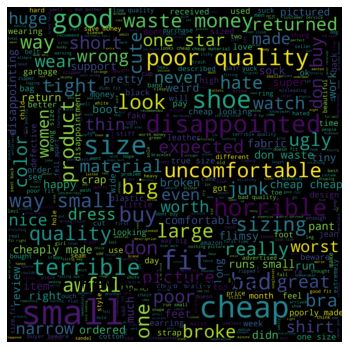

In [44]:

show_wordcloud(cluster1["summaryClean"][0], title = "Review Score One")

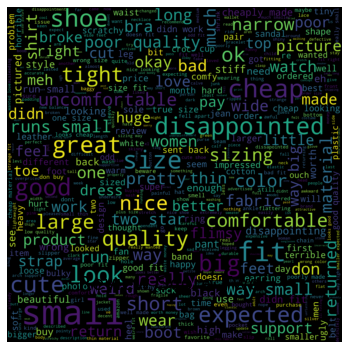

In [46]:
show_wordcloud(cluster1["summaryClean"][1] , title = "Review Score Two")

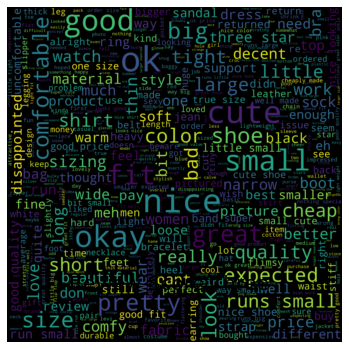

In [55]:
show_wordcloud(cluster1["summaryClean"][2], title = "Review Score Three")

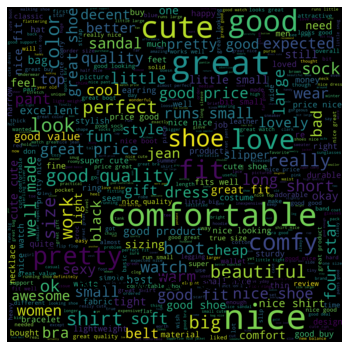

In [53]:
show_wordcloud(cluster1["summaryClean"][3], title = "Review Score Four")

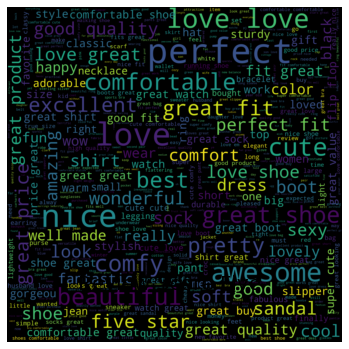

In [51]:
show_wordcloud(cluster1["summaryClean"][4], title = "Review Score Five")